# Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates  as md
import numpy             as np
import pandas            as pd
import seaborn           as sns
import datetime
import time
import collections
import operator
import re

import sys
sys._enablelegacywindowsfsencoding()

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

from pandas                   import concat
from math                     import sqrt
from IPython.display          import Image
from glob                     import glob

from sklearn.model_selection  import train_test_split
from sklearn.preprocessing    import MinMaxScaler, LabelEncoder
from sklearn.metrics          import confusion_matrix
from keras.models             import Sequential
from keras.layers             import Dense, LSTM, Dropout
from keras.utils              import np_utils


Using TensorFlow backend.


# Notebook Variables

In [2]:
#directories      = ["C:/Users/T-Gamer/Documents/Projetos - Git/FinalCourseAssignment/Dataset/20171203/", "C:/Users/T-Gamer/Documents/Projetos - Git/FinalCourseAssignment/Dataset/20171129/"]
directories      = ["C:/Users/T-Gamer/Documents/Git Projects/TCC-Lunar/FinalCourseAssignment/Dataset/20180315/UFRJ/"]

file_delimiter   = '\t'


window_size              = 0
should_use_normalization = True

pothole_output   = 1
speedbump_output = 2
default_output   = 0

tilt_threshold   = 30
n_reg_lag        = 60
features         = ['accelerometer_X','accelerometer_Y','accelerometer_Z','output']

# Functions 

In [3]:
def get_files_with_regex(directories, regex):  
    filtered_files = []

    for directory in directories:
        
        no_filter_files = get_files_from_directories([directory])

        for item in no_filter_files:
            file  = item.split('\\')[-1]
            match = re.search(regex, file) 

            if match:
                filtered_files.append(item)
        
    return filtered_files

def extract_datetime_from_file(file):
    
    regex = '_(\d{4})_(\d{1,2})_(\d{1,2})_(\d{1,2})_(\d{1,2})_(\d{1,2})'
    
    match = re.search(regex, file) 

    if match:
        year   = match.group(1)
        month  = match.group(2)
        day    = match.group(3)
        '''
        hour   = match.group(4)
        minute = match.group(5)
        second = match.group(6)
        
        if hour is "0":
            hour = "12"
        elif hour is "1":
            hour = "13"
        datetime_str = "{}-{}-{} {}:{}:{}".format(year, month, day, hour, minute, second)
        
        datetime_obj = datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
        '''
        date_string = "{}-{}-{}".format(year, month, day)
        
        return date_string
    else:
        return None


def join_files_to_unique_dataframe(files):
    
    speedbump_df_list = []
    pothole_df_list   = []
    general_df_list   = []
    
    speedbump_files = get_files_with_regex(directories, '^(SpeedBump_).+')
    pothole_files   = get_files_with_regex(directories, '^(Pothole_).+')
    general_files   = get_files_with_regex(directories, '^(?!SpeedBump|Pothole).+')

    for f in speedbump_files:
        tmp_df = pd.read_csv(f, delimiter = file_delimiter)
        dt_str = extract_datetime_from_file(f)
        
        dt_list = []
        for i in range(len(list(tmp_df['realtime']))):
            full_datetime_str = "{} {}".format(dt_str, tmp_df['realtime'][i])
            dt_list.append(string_operation_to_datetime(_datetimestr = full_datetime_str, _format = '%Y-%m-%d %H:%M:%S',_milliseconds = 0)) #int(list(tmp_df['timestamp'])[i])
        tmp_df['datetime'] = dt_list
        
        speedbump_df_list+= [tmp_df]
   
    for f in pothole_files:
        tmp_df = pd.read_csv(f, delimiter = file_delimiter)
        dt_str = extract_datetime_from_file(f)
        
        dt_list = []
        for i in range(len(list(tmp_df['realtime']))):
            full_datetime_str = "{} {}".format(dt_str, tmp_df['realtime'][i])
            dt_list.append(string_operation_to_datetime(_datetimestr = full_datetime_str, _format = '%Y-%m-%d %H:%M:%S',_milliseconds = 0)) #int(list(tmp_df['timestamp'])[i])
        tmp_df['datetime'] = dt_list
        
        pothole_df_list+= [tmp_df]
        
    for f in general_files:
        tmp_df = pd.read_csv(f, delimiter = file_delimiter)
        dt_str = extract_datetime_from_file(f)
        
        dt_list = []
        for i in range(len(list(tmp_df['realtime']))):
            full_datetime_str = "{} {}".format(dt_str, tmp_df['realtime'][i])
            dt_list.append(string_operation_to_datetime(_datetimestr = full_datetime_str, _format = '%Y-%m-%d %H:%M:%S',_milliseconds = 0)) #int(list(tmp_df['timestamp'])[i])
        tmp_df['datetime'] = dt_list
        
        general_df_list+= [tmp_df]

    #speedbump_df_list +=[pd.read_csv(f, delimiter = file_delimiter) for f in speedbump_files]
    #pothole_df_list   +=[pd.read_csv(f, delimiter = file_delimiter) for f in pothole_files]
    #general_df_list   +=[pd.read_csv(f, delimiter = file_delimiter) for f in general_files]

    return pd.concat(general_df_list), pd.concat(pothole_df_list), pd.concat(speedbump_df_list)


def get_files_from_directories(directories, filetype = "csv", pattern = "*."):
    files      = []
    _pattern   = pattern + filetype
    try:
        for directory in directories:
            for dir,_,_ in os.walk(directory):
                files.extend(glob(os.path.join(dir, _pattern)))
    except:
        print("\Error to get files from directories. Do you do \"import os\" and \"from glob import glob\" ?")
        
    return files


def window_normalization(serie, window_size):
    elems     = np.zeros(len(serie))
    pos_begin = pos_end = 0
    media     = std = 0.0
    count     = 0
    
    while count <= (len(elems) - window_size):
        
        #Is the process at the end?
        if (count + window_size == len(elems)):
            aux = count - 1
            while count < len(elems):
                elems[count] = elems[aux]
                count +=1
            break
            
        pos_end = pos_begin + window_size
        media   = np.mean(serie[pos_begin:pos_end])
        std     = np.std (serie[pos_begin:pos_end])
        
        elems[pos_begin] += np.sqrt((serie[pos_end] - media)**2/std)

        count     +=1
        pos_begin +=1
    
    return elems.tolist()
    
    
def full_normalization(serie):
    return np.sqrt((serie - np.mean(serie))**2/np.std(serie))


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

def string_operation_to_datetime(_datetimestr = "", _format = "", _milliseconds = 0, _seconds = 0, _minutes = 0, _hours = 0):
    
    # First case: Just sum values with current datetime
    if _datetimestr is "" and _format is "":
        current_date = datetime.datetime.strptime(datetime.datetime.today().strftime('%Y %m %d %H %M %S %f'), "%Y %m %d %H %M %S %f")
        current_date = current_date + datetime.timedelta(hours = _hours, minutes = _minutes, seconds = _seconds, milliseconds = _milliseconds)
        return str(current_date)
    
    # Second case: Sum values with given datetime
    if _datetimestr is not "" and _format is not "":
        try:
            current_date = datetime.datetime.strptime(_datetimestr, _format)
            current_date = current_date + datetime.timedelta(hours = _hours, minutes = _minutes, seconds = _seconds, milliseconds = _milliseconds)
            return str(current_date)
        except:
            print('Are you sure you given the right format?')
            return None
        
    print('This method have two possible cases.\nFirst: _datetimestr and _format not filled.\nSecond:_datetimestr and _format filled\n')
    return None

def insert_repeated_values_on_dataframe(dataframe, column_name, index_list, value, seconds = 1, both_side = True, forward = True):
    
    list_timestamp = []
    for dt in dataframe['datetime']:
        list_timestamp.append(int(time.mktime(time.strptime(dt,'%Y-%m-%d %H:%M:%S.%f')))) #'%Y-%m-%d %H:%M:%S.%f'
    
    df_general['datetime_timestamp'] = list_timestamp

    for idx in index_list:
        
        if both_side:
            begin_date = list((dataframe.loc[[idx]])['datetime_timestamp'].values)[0] - seconds
            end_date   = list((dataframe.loc[[idx]])['datetime_timestamp'].values)[0] + seconds
        else:
            if forward:
                begin_date = list((dataframe.loc[[idx]])['datetime_timestamp'].values)[0] - 0
                end_date   = list((dataframe.loc[[idx]])['datetime_timestamp'].values)[0] + seconds
            else:
                begin_date = list((dataframe.loc[[idx]])['datetime_timestamp'].values)[0] - seconds
                end_date   = list((dataframe.loc[[idx]])['datetime_timestamp'].values)[0] + 0
                
        dataframe.loc[(dataframe['datetime_timestamp'] <= end_date) & (df_general['datetime_timestamp'] >= begin_date), column_name] = value
            
    return dataframe


def convert_output_to_categorical_mode(y_train, y_test):
    
    outputs, result = list(), tuple()
    
    outputs.append(x_train)
    outputs.append(x_test)

    for output in outputs:
        unique_sequence_out = []
        for sequence in output: 
            counter = collections.Counter(list(sequence[:,-1]))
            counter = dict(counter)

            sorted_output_by_frequency = sorted(counter.items(), key=operator.itemgetter(1))
            sorted_output_by_frequency.reverse()


            if (sorted_output_by_frequency[0][0] == 0):
                unique_sequence_out.append([1,0,0])
            elif (sorted_output_by_frequency[0][0] == 1):
                unique_sequence_out.append([0,1,0])
            else:
                unique_sequence_out.append([0,0,1])

        if not result:
            result = (np.asarray(unique_sequence_out),)
        else:
            result = result + (np.asarray(unique_sequence_out),)

    return result



def temporal_data_to_supervised_learning(features, n_reg_lag = 60):
    
    # Apply filter on general dataframe
    values = df_general.filter(features, axis=1).values

    # Specify the number of registers lag and n_features
    # n_reg_lag = 60 means that i wanna process 60 values (2 seconds from past) from past to predict the current timestep
    n_features = len(features)

    # Frame as supervised learning
    reframed = series_to_supervised(values, n_reg_lag, 1)

    # Drop columns we don't want to predict
    unnecessary_columns  = []
    unnecessary_columns += [('var%d(t)' % (j+1)) for j in range(len(features) -1)]
    reframed.drop(unnecessary_columns, axis=1, inplace=True)
    
    return reframed

def split_data_to_training_and_test(dataframe, n_features, n_reg_lag, test_size = 0.2):
    
    # Split into train and test sets
    values = dataframe.values

    n_obs = n_features * n_reg_lag

    # Split data into training and test
    x_train, x_test, y_train, y_test = train_test_split(values[:,:n_obs], values[:,[n_obs]], test_size=test_size, random_state=42)

    # reshape input to be 3D [samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0], n_reg_lag, n_features))
    x_test  = x_test.reshape((x_test.shape[0]  , n_reg_lag, n_features))

    print("Train's data shape: {},{}".format(x_train.shape, y_train.shape))
    print("Test's  data shape: {},{}".format(x_test.shape,  y_test.shape ))
    
    return (x_train, x_test, y_train, y_test)


def build_confusion_matrix(y_test, yhat, labels = ['Default','Pothole', 'SpeedBump']):
    
    y_pred = np.argmax(yhat, axis=1)
    y_true = np.argmax(y_test, axis=1)

    classes = labels
    
    y_true = [classes[i] for i in y_true]
    y_pred = [classes[i] for i in y_pred]
    
    cm = confusion_matrix(y_true, y_pred, labels = classes)
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='d');
    sns.set(font_scale=2)

    # Labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    
def plot_tooltip_bokeh(axisSensor, dataframe, dataframe_pothole,dataframe_speedBump, _color = 'red', pos_df_pothole = 15, pos_df_speedBump = 18):
    from bokeh.models   import HoverTool, BoxZoomTool,UndoTool, SaveTool
    from bokeh.charts   import Line
    from bokeh.plotting import output_notebook, show
    from bokeh.models   import  BasicTickFormatter

    output_notebook()
    
    data      = {axisSensor: dataframe[axisSensor].tolist()}
    index     = dataframe['timestamp'].tolist()
    dataframe = pd.DataFrame(data=data, index=index)
    dataframe = dataframe.assign(x=dataframe.index)
    columns   = dataframe.columns.values.tolist()
    columns.remove('x')

    dataframe_pothole['Pothole occurrence']     = pos_df_pothole
    dataframe_speedBump['SpeedBump occurrence'] = pos_df_speedBump

    hover = HoverTool(
            tooltips=[
                ("lineNumberFile", "$index"),
                ("Timestamp, accelerometer", "($x{int}, $y)")
            ]
        )

    # Sensor's Data
    p = Line(data = dataframe, x ='x', legend = False,
             title="AXIS " + axisSensor[-1] + " - ACCELEROMETER",
             xlabel='Timestamp', ylabel='m/s^2',
             width=950, height=400, color=_color,
             notebook=True, tools = [hover,BoxZoomTool(),UndoTool(),SaveTool()])

    p.y_range.end   = 25
    p.x_range.start = dataframe['x'].iloc[0] - 10
    p.x_range.end   = dataframe['x'].iloc[-1]+ 1000

    # Pothole
    p.circle(dataframe_pothole['timestamp'].tolist(), dataframe_pothole['Pothole occurrence'].tolist(),fill_color="white",size=8)

    # SpeedBump
    p.inverted_triangle(dataframe_speedBump['timestamp'].tolist(), dataframe_speedBump['SpeedBump occurrence'].tolist(),size=8, color="#DE2D26")

    p.xaxis.formatter=BasicTickFormatter(use_scientific=False)
    show(p)

In [44]:
#string_operation_to_datetime('2018-01-01T04:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%fZ",_hours=2)

In [36]:
# Get dataframes from csv files
df_general, df_pothole, df_speedbump= join_files_to_unique_dataframe(get_files_from_directories(directories))

# Code

In [17]:
'''
counter_0 = 0
counter_1 = 0
counter_2 = 0

for item in y_train:
    
    if item[0] == 1:
        counter_0 +=1
        
    if item[1] == 1:
        counter_1 +=1
        
    if item[2] == 1:
        counter_2 +=1

print(counter_0)
print(counter_1)
print(counter_2)

'''

'\ncounter_0 = 0\ncounter_1 = 0\ncounter_2 = 0\n\nfor item in y_train:\n    \n    if item[0] == 1:\n        counter_0 +=1\n        \n    if item[1] == 1:\n        counter_1 +=1\n        \n    if item[2] == 1:\n        counter_2 +=1\n\nprint(counter_0)\nprint(counter_1)\nprint(counter_2)\n\n'

In [12]:
# Get Paths from specific file
#speedbumpPath = get_files_from_directories(directories, pattern = "SpeedBump_Postognv*.")[0]
#potholePath   = get_files_from_directories(directories, pattern = "Pothole_Postognv*.")[0]
#generalPath   = get_files_from_directories(directories, pattern = "Postognv*.")[0]
speedbumpPath = get_files_from_directories(directories, pattern = "SpeedBump_FundaoManual1*.")[0]
potholePath   = get_files_from_directories(directories, pattern = "Pothole_FundaoManual1*.")[0]
generalPath   = get_files_from_directories(directories, pattern = "FundaoManual1*.")[0]


# Reading csv files
df_general    = pd.read_csv(generalPath, delimiter   = file_delimiter)
df_pothole    = pd.read_csv(potholePath, delimiter   = file_delimiter)
df_speedbump  = pd.read_csv(speedbumpPath, delimiter = file_delimiter)


# Create "output" column
df_general.loc[df_general['timestamp'].isin(list(df_pothole['timestamp']))  , 'output'] = pothole_output
df_general.loc[df_general['timestamp'].isin(list(df_speedbump['timestamp'])), 'output'] = speedbump_output


# Put default_output on rows with NaN values
df_general['output'] = df_general['output'].fillna(default_output)


# Add the values from "timestamp" column in the current datetime and a new datetime column is created to be used as index
datetime_values = []
for value in list(df_general['timestamp']):
    result = string_operation_to_datetime(_milliseconds = int(value))
    if result is not None:
        datetime_values.append(result)
df_general['datetime'] = datetime_values
df_general.set_index('datetime')


# Add event's values in a range of seconds in the dataframe
df_general = insert_repeated_values_on_dataframe(df_general, 'output', list(df_general[df_general['output'] == pothole_output].index)  , pothole_output,   seconds = 1, both_side = True)
df_general = insert_repeated_values_on_dataframe(df_general, 'output', list(df_general[df_general['output'] == speedbump_output].index), speedbump_output, seconds = 1, both_side = True)


# Remove dataframe's rows with high tilt
df_general = df_general[(df_general['tilt'] > tilt_threshold)]


# Normalize data
if should_use_normalization:
    if window_size < 1:
        df_general['accelerometer_X'] = full_normalization(df_general['accelerometer_X'])
        df_general['accelerometer_Y'] = full_normalization(df_general['accelerometer_Y'])
        df_general['accelerometer_Z'] = full_normalization(df_general['accelerometer_Z'])
    else:
        df_general['accelerometer_X'] = window_normalization(df_general['accelerometer_X'], window_size)
        df_general['accelerometer_Y'] = window_normalization(df_general['accelerometer_Y'], window_size)
        df_general['accelerometer_Z'] = window_normalization(df_general['accelerometer_Z'], window_size)
        

# Convert temporal data to supervised problem
reframed = temporal_data_to_supervised_learning(features, n_reg_lag)


# Split data into training and test arrays
x_train, x_test, y_train, y_test = split_data_to_training_and_test(reframed, len(features), n_reg_lag)


# Convert output to categorical mode
y_train, y_test = convert_output_to_categorical_mode(y_train, y_test)


# Remove target column from x_train and x_test
x_train = x_train[:, :, :-1]
x_test  = x_test[:, :, :-1]

Train's data shape: (6294, 60, 4),(6294, 1)
Test's  data shape: (1574, 60, 4),(1574, 1)


In [13]:
df_general

,accelerometer_X,accelerometer_Y,accelerometer_Z,latitude,longitude,tilt,timestamp,datetime,output,datetime_timestamp
0,0.955192,1.236854,0.156215,-22.923639,-43.233107,38,91,2018-03-21 08:52:25.160706,0.0,1521633145
1,0.775120,1.533133,0.037147,-22.923639,-43.233107,36,209,2018-03-21 08:52:25.278706,0.0,1521633145
2,0.158963,0.342463,0.044437,-22.923639,-43.233107,45,389,2018-03-21 08:52:25.459717,0.0,1521633145
3,0.370499,1.093204,0.497986,-22.923639,-43.233107,45,576,2018-03-21 08:52:25.646717,0.0,1521633145
4,0.013978,0.674427,1.271931,-22.923639,-43.233107,35,753,2018-03-21 08:52:25.823717,0.0,1521633145
5,0.283122,1.179105,0.242885,-22.923639,-43.233107,39,936,2018-03-21 08:52:26.006717,0.0,1521633146
6,0.014543,1.198659,0.864011,-22.923639,-43.233107,44,1110,2018-03-21 08:52:26.180717,0.0,1521633146
7,0.691367,1.259452,0.938981,-22.858914,-43.230892,34,1288,2018-03-21 08:52:26.358717,0.0,1521633146
8,0.631947,0.757284,0.767668,-22.858914,-43.230892,44,1475,2018-03-21 08:52:26.545717,0.0,1521633146
9,0.349672,1.414593,0.128226,-22.858914,-43.230892,49,1655,2018-03-21 08:52:26.725717,0.0,1521633146


In [14]:
reframed

,var1(t-60),var2(t-60),var3(t-60),var4(t-60),var1(t-59),var2(t-59),var3(t-59),var4(t-59),var1(t-58),var2(t-58),...,var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
60,0.955192,1.236854,0.156215,0.0,0.775120,1.533133,0.037147,0.0,0.158963,0.342463,...,0.0,0.120934,0.503689,0.315649,2.0,0.567773,1.174083,0.733918,2.0,2.0
61,0.775120,1.533133,0.037147,0.0,0.158963,0.342463,0.044437,0.0,0.370499,1.093204,...,2.0,0.567773,1.174083,0.733918,2.0,0.504165,1.287071,0.595004,2.0,2.0
62,0.158963,0.342463,0.044437,0.0,0.370499,1.093204,0.497986,0.0,0.013978,0.674427,...,2.0,0.504165,1.287071,0.595004,2.0,0.013978,2.973823,0.592800,2.0,2.0
63,0.370499,1.093204,0.497986,0.0,0.013978,0.674427,1.271931,0.0,0.283122,1.179105,...,2.0,0.013978,2.973823,0.592800,2.0,0.073963,0.953129,1.757700,2.0,2.0
64,0.013978,0.674427,1.271931,0.0,0.283122,1.179105,0.242885,0.0,0.014543,1.198659,...,2.0,0.073963,0.953129,1.757700,2.0,0.934366,0.774860,0.972730,2.0,2.0
65,0.283122,1.179105,0.242885,0.0,0.014543,1.198659,0.864011,0.0,0.691367,1.259452,...,2.0,0.934366,0.774860,0.972730,2.0,0.368687,1.683784,1.799594,2.0,2.0
66,0.014543,1.198659,0.864011,0.0,0.691367,1.259452,0.938981,0.0,0.631947,0.757284,...,2.0,0.368687,1.683784,1.799594,2.0,0.807830,0.370083,2.846280,2.0,2.0
67,0.691367,1.259452,0.938981,0.0,0.631947,0.757284,0.767668,0.0,0.349672,1.414593,...,2.0,0.807830,0.370083,2.846280,2.0,0.401962,0.255116,0.052581,2.0,2.0
68,0.631947,0.757284,0.767668,0.0,0.349672,1.414593,0.128226,0.0,0.518425,0.666894,...,2.0,0.401962,0.255116,0.052581,2.0,0.801265,1.643610,1.085183,2.0,2.0
69,0.349672,1.414593,0.128226,0.0,0.518425,0.666894,0.129755,0.0,0.503600,0.837099,...,2.0,0.801265,1.643610,1.085183,2.0,0.482773,2.828194,0.888941,2.0,2.0


# Design Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 300)               364800    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 903       
Total params: 365,703
Trainable params: 365,703
Non-trainable params: 0
_________________________________________________________________
None
Train on 6294 samples, validate on 1574 samples
Epoch 1/50
6294/6294 [==============================] - 15s 2ms/step - loss: 0.4152 - acc: 0.8953 - val_loss: 0.2991 - val_acc: 0.9307
Epoch 2/50
6294/6294 [==============================] - 14s 2ms/step - loss: 0.3083 - acc: 0.9256 - val_loss: 0.3116 - val_acc: 0.9307
Epoch 3/50
6294/6294 [==============================] - 14s 2ms/step - loss: 0.2782 - acc: 0.9256 - val_loss: 0.2242 - val_acc: 0.9301
Epoch 4/50
6294/6294 [==============================] - 13s 2ms/step - los

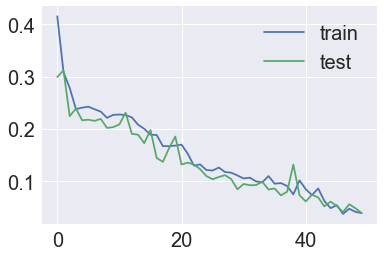

In [34]:
# design network
model = Sequential()
model.add(LSTM(300,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# summarize the model
print(model.summary())

#fit network
history = model.fit(x_train, y_train, epochs=50, batch_size=200, validation_data=(x_test, y_test), verbose=1, shuffle=False)

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# Result from machine learning model

In [23]:
y_pred = np.argmax(yhat, axis=1)
y_true = np.argmax(y_test, axis=1)


In [45]:
y_pred_idx = [int(arr) for arr in np.argwhere(y_pred == 2)]
y_true_idx = [int(arr) for arr in np.argwhere(y_true == 2)]

print(y_pred_idx)
print(y_true_idx)


intersection = list(set(y_pred_idx) & set(y_true_idx))
print(len(intersection))
exclusive = list(set(y_pred_idx) ^ set(y_true_idx))
print(len(exclusive))
#list(set(y_pred_idx).intersection(y_true_idx))
#print(len(list(set(y_pred_idx).intersection(y_true_idx))))

[12, 22, 28, 69, 78, 86, 88, 121, 130, 141, 164, 197, 218, 255, 264, 267, 287, 322, 336, 373, 379, 382, 416, 435, 452, 455, 464, 539, 549, 555, 595, 694, 706, 837, 839, 870, 984, 1021, 1058, 1083, 1118, 1264, 1278, 1305, 1347, 1427, 1434, 1445, 1535, 1547, 1558, 1562, 1563, 1603, 1647, 1654]
[21, 34, 69, 79, 94, 113, 121, 130, 134, 141, 144, 164, 218, 232, 259, 267, 312, 335, 336, 341, 361, 373, 379, 382, 455, 462, 464, 487, 492, 553, 555, 574, 575, 595, 609, 629, 685, 694, 709, 716, 725, 730, 773, 787, 808, 813, 826, 827, 834, 849, 852, 853, 878, 916, 930, 957, 983, 989, 992, 1044, 1057, 1060, 1064, 1065, 1193, 1196, 1198, 1264, 1278, 1325, 1337, 1340, 1345, 1439, 1445, 1488, 1502, 1517, 1545, 1562, 1573, 1589, 1603, 1604, 1628, 1630, 1633, 1635]
21
102


Accuracy: 91.49%


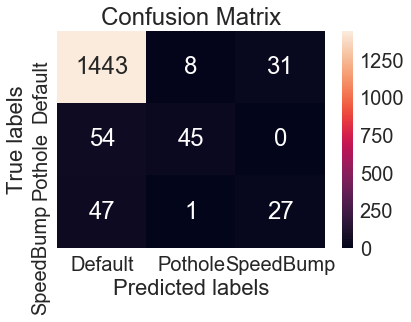

In [37]:
# Make a prediction
yhat   = model.predict(x_test)

# Print Accuracy value
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Build Confusion Matrix
build_confusion_matrix(y_test, yhat)